## Import Libraries Modules

In [56]:
import sys
parentdir = 'C:\\Users\\Jerzy\\Documents\\GitHub\\BAMT'
sys.path.insert(0, parentdir)


In [57]:
import time
from tqdm.notebook import tqdm
from graph.precision_recall import precision_recall
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import bamt

from bayesian.train_bn import structure_learning
from preprocess.discretization import discretization, get_nodes_type, code_categories
from visualization.visualization import draw_BN, draw_comparative_hist
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression

mpl.style.use('seaborn')
plt.rcParams.update({'font.size': 22})


## Functions to calculate possible edges

In [58]:
def get_n_nearest(data, columns, corr=False, number_close=5):
    """Returns n nearest neighbors for every column of dataframe, added into list

    Args:
        data (DataFrame): Proximity matrix
        columns (list): df.columns.tolist()
        corr (bool, optional): _description_. Defaults to False.
        number_close (int, optional): Number of nearest neighbors. Defaults to 5.

    Returns:
        groups
    """
    groups = []
    if corr:
        for c in columns:
            close_ind = data[c].sort_values(ascending=False).index.tolist()
            groups.append(close_ind[0:number_close+1])
    else:
        for c in columns:
            close_ind = data[c].sort_values().index.tolist()
            groups.append(close_ind[0:number_close+1])

    return groups


def get_mutual_info_score_matrix(df, df_coded, continuous=False):
    """Returns matrix of mutual information score of the dataframe, dataframe must be coded first if it contains categorical data

    Args:
        df (DataFrame): data
        df_coded (DataFrame): same data, but coded

    Returns:
        df_distance: mutual information matrix
    """

    df_distance = pd.DataFrame(data=np.zeros(
        (len(df.columns), len(df.columns))), columns=df.columns)
    df_distance.index = df.columns

    if continuous == False:
        for c1 in df.columns:
            for c2 in df.columns:
                dist = mutual_info_score(
                    df_coded[c1].values, df_coded[c2].values)
                df_distance.loc[c1, c2] = dist

    else:
        df_distance = df_coded.corr(method='pearson')

    return df_distance


def get_brave_matrix(df, proximity_matrix, n_nearest=5):
    """Returns matrix Brave coeffitients of the DataFrame, requires proximity measure to be calculated

    Args:
        df (DataFrame): data
        proximity_matrix (DataFrame): might be generated by get_mutual_info_score_matrix() function or correlation from scipy
        n_nearest (int, optional): _description_. Defaults to 5.

    Returns:
        brave_matrix: DataFrame of Brave coefficients
    """

    brave_matrix = pd.DataFrame(data=np.zeros(
        (len(df.columns), len(df.columns))), columns=df.columns)
    brave_matrix.index = df.columns

    groups = get_n_nearest(proximity_matrix, df.columns.tolist(),
                           corr=True, number_close=n_nearest)

    for c1 in df.columns:
        for c2 in df.columns:
            a = .0
            b = .0
            c = .0
            d = .0
            if c1 != c2:
                for g in groups:
                    if (c1 in g) & (c2 in g):
                        a += 1
                    if (c1 in g) & (c2 not in g):
                        b += 1
                    if (c1 not in g) & (c2 in g):
                        c += 1
                    if (c1 not in g) & (c2 not in g):
                        d += 1
                br = (a * len(groups) + (a + c)*(a + b)) / ((math.sqrt((a + c) *
                                                                       (b + d))) * (math.sqrt((a + b) * (c + d))))
                brave_matrix.loc[c1, c2] = br

    return brave_matrix


def get_possible_edges_by_brave(df, proximity_matrix, n_nearest=5, custom_threshold=False, threshold=.0):
    """Returns list of possible edges for structure learning

    Args:
        df (DataFrame): data
        proximity_matrix (DataFrame): might be generated by get_mutual_info_score_matrix() function, correlation etc.
        n_nearest (int, optional): Number of Nearest neighbors, hyperparameter. Defaults to 5.
        custom_threshold (bool, optional): Must be set true to redact threshold, then set threshold. Defaults to False.
        threshold (float, optional): Threshold for edge candidates to be passed to possible edges, threshold. Defaults to 0.

    Returns:
        Possible edges: list of possible edges
    """
    brave_matrix = get_brave_matrix(df, proximity_matrix, n_nearest)
    
    possible_edges = []

    if custom_threshold == False:
        for c1 in df.columns:
            for c2 in df.columns:
                if brave_matrix.loc[c1, c2] > brave_matrix.max(numeric_only='true').max()*0.3:
                    possible_edges.append((c1, c2))
    else:
        for c1 in df.columns:
            for c2 in df.columns:
                if brave_matrix.loc[c1, c2] > threshold:
                    possible_edges.append((c1, c2))

    return possible_edges


## Import data, code categorical data

In [59]:
df = pd.read_csv('data/arth150.csv')


In [60]:
get_nodes_type(df)


{'4': 'cont',
 '8': 'cont',
 '13': 'cont',
 '20': 'cont',
 '26': 'cont',
 '38': 'cont',
 '47': 'cont',
 '61': 'cont',
 '63': 'cont',
 '78': 'cont',
 '81': 'cont',
 '86': 'cont',
 '93': 'cont',
 '96': 'cont',
 '100': 'cont',
 '101': 'cont',
 '108': 'cont',
 '111': 'cont',
 '126': 'cont',
 '135': 'cont',
 '144': 'cont',
 '155': 'cont',
 '161': 'cont',
 '181': 'cont',
 '187': 'cont',
 '197': 'cont',
 '198': 'cont',
 '209': 'cont',
 '211': 'cont',
 '219': 'cont',
 '226': 'cont',
 '234': 'cont',
 '245': 'cont',
 '248': 'cont',
 '256': 'cont',
 '269': 'cont',
 '272': 'cont',
 '281': 'cont',
 '289': 'cont',
 '296': 'cont',
 '299': 'cont',
 '328': 'cont',
 '331': 'cont',
 '342': 'cont',
 '360': 'cont',
 '363': 'cont',
 '368': 'cont',
 '377': 'cont',
 '378': 'cont',
 '412': 'cont',
 '414': 'cont',
 '422': 'cont',
 '443': 'cont',
 '444': 'cont',
 '452': 'cont',
 '454': 'cont',
 '460': 'cont',
 '464': 'cont',
 '479': 'cont',
 '480': 'cont',
 '496': 'cont',
 '519': 'cont',
 '537': 'cont',
 '539': 

In [61]:
df_coded, coder = code_categories(df, 'label', df.columns)
df_coded


,4,8,13,20,26,38,47,61,63,78,...,739,758,767,778,779,781,783,786,793,798
0,5746,710,9035,2117,2685,5675,8908,8864,3272,1186,...,7220,9607,2578,6688,4706,7337,6892,3782,9987,7974
1,9441,2323,700,7175,235,549,6071,1533,7594,4963,...,4856,3270,8391,8409,7444,8991,6831,877,709,7953
2,7071,7423,2528,4075,1392,2157,2480,5376,9488,8028,...,2960,2259,1941,3625,5794,8630,9576,1124,6421,6150
3,4240,9492,7520,4617,8177,4120,3778,6081,4436,5882,...,6942,5215,6760,2393,4946,809,1760,2184,3376,4179
4,4124,6364,4245,1372,5144,4013,2159,9785,6153,4375,...,3255,8709,9456,2024,3704,3369,492,3772,2395,2823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7435,6735,1282,6327,7657,3593,8212,7594,2962,3124,...,5053,9086,9609,7008,544,8067,7819,2680,1275,9913
9996,5806,7691,694,9462,2908,2245,4506,1618,7320,7735,...,723,2877,1672,1253,7617,9595,8720,5740,464,2216
9997,1143,1673,3532,1692,5007,8911,1575,5692,4759,1506,...,2980,4511,8148,9629,7839,4571,8662,6147,425,129
9998,6839,1152,6595,8156,7967,5013,6441,9978,5167,6129,...,2137,2252,1191,8728,6202,2492,1836,3372,5868,7881


In [62]:
structure_right = pd.read_csv(
    'data/arth150_true.csv')
sparsebn_edges = pd.read_csv(
    'data/arth150_sparsebn.csv')
bidag_edges = pd.read_csv(
    'data/arth150_bidag.csv')

print(structure_right, sparsebn_edges, bidag_edges)


      V1   V2
0     20  573
1     47  331
2     47  479
3     47  714
4     47  736
..   ...  ...
145  783  640
146  783  679
147  783  781
148  793   47
149  793  479

[150 rows x 2 columns]        V1    V2
0      X4  X539
1     X13  X331
2     X13  X422
3     X20  X573
4     X26  X781
..    ...   ...
147  X783  X454
148  X783  X547
149  X783  X640
150  X783  X781
151  X786  X422

[152 rows x 2 columns]       V1   V2
0      8    4
1      8   61
2      8   93
3      8  126
4      8  209
..   ...  ...
240  786  793
241  793  452
242  793  479
243  793  651
244  798  779

[245 rows x 2 columns]


## Experiments

Calculate SHD score of baselines

In [63]:
pr_sparsebn = precision_recall(sparsebn_edges, structure_right)['SHD']
pr_bidag = precision_recall(bidag_edges, structure_right)['SHD']

print(pr_sparsebn, pr_bidag)


298 391


In [64]:
experiment_range = []
time_of_experiment = []
n = 0
for i in range(10):
    n += 10
    experiment_range.append(n)
experiment_range.append(106)

experiment_range

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 106]

In [65]:
for i in tqdm(experiment_range):
    start_time = time.time()
    df_loop = df.sample(n=i, axis='columns')
    df_discrete, _ = discretization(df_loop, 'equal_frequency', df_loop.columns)
    df_mis = get_mutual_info_score_matrix(df_loop, df_loop, continuous=True)
    possible_edges = get_possible_edges_by_brave(df_discrete, proximity_matrix=df_mis)
    bn = structure_learning(df_discrete, 'HC', get_nodes_type(
        df_discrete), 'K2', white_list=possible_edges)
    brave_edges = []
    for e in bn['E']:
            brave_edges.append((e[0], e[1]))
    time_of_experiment.append(time.time() - start_time)


  0%|          | 0/11 [00:00<?, ?it/s]

In [66]:
time_of_experiment

[0.1529984474182129,
 1.2449939250946045,
 1.4873206615447998,
 1.851322889328003,
 3.1147584915161133,
 4.146496057510376,
 5.825303792953491,
 8.130999565124512,
 8.644008159637451,
 10.624605178833008,
 12.261115789413452]

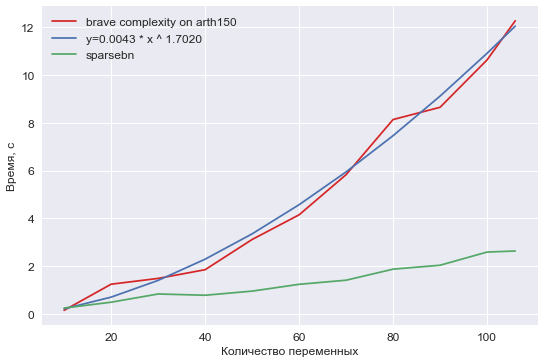

In [67]:
sparsebn_time = [0.2481091, 0.4924049, 0.836025, 0.78403, 0.9560311, 1.241001, 1.41247, 1.874364, 2.039, 2.589412, 2.634012]


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Количество переменных', fontsize = 12)
ax1.set_ylabel('Время, с', fontsize = 12)
ax1.plot(experiment_range, time_of_experiment, color=color, label = 'brave complexity on arth150')
ax1.plot(experiment_range, 0.0043 * np.power(experiment_range, 1.7020), label = 'y=0.0043 * x ^ 1.7020')
ax1.plot(experiment_range, sparsebn_time, label = 'sparsebn')

ax1.legend(fontsize = 12)

#ax2 = ax1.twinx()

#color = 'tab:blue'
#ax2.set_ylabel('Время, с', color=color)
#ax2.plot(range_of_n_nearest, time_n_nearest, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.xticks(rotation='horizontal', fontsize = 12)
plt.yticks(rotation='horizontal', fontsize = 12)
plt.show()

In [68]:
df = pd.read_csv('data/pigs.csv')

In [69]:
experiment_range = []
time_of_experiment = []
n = 0
for i in range(20):
    n += 20
    experiment_range.append(n)
experiment_range.append(440)

experiment_range

[20,
 40,
 60,
 80,
 100,
 120,
 140,
 160,
 180,
 200,
 220,
 240,
 260,
 280,
 300,
 320,
 340,
 360,
 380,
 400,
 440]

In [ ]:
for i in tqdm(experiment_range):
    start_time = time.time()
    df_loop = df.sample(n=i, axis='columns')
    df_mis = get_mutual_info_score_matrix(df_loop, df_loop,)
    possible_edges = get_possible_edges_by_brave(df_loop, proximity_matrix=df_mis)
    bn = structure_learning(df_loop, 'HC', get_nodes_type(
        df_loop), 'K2', white_list=possible_edges)
    brave_edges = []
    for e in bn['E']:
            brave_edges.append((e[0], e[1]))
    time_of_experiment.append(time.time() - start_time)

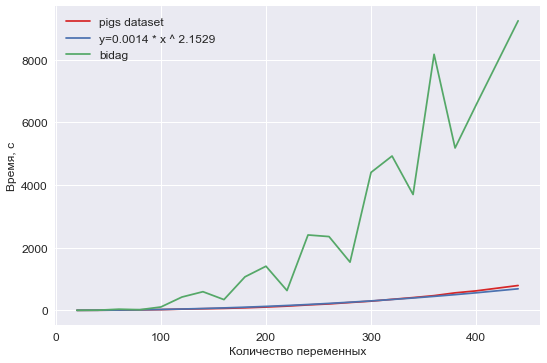

In [ ]:
brave_time = [1.521608, 4.30287, 36.94609, 20.49653, 107.5941, 424.94136, 594.9396, 343.15086, 1069.3152, 1408.1304, 632.2404, 2405.3274, 2354.1102, 1538.4378, 4401.6984, 4924.4436, 3696.9624, 8169.4764, 5181.6456, 6553.476, 9239.5368]
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Количество переменных', fontsize = 12)
ax1.set_ylabel('Время, с', fontsize = 12)
ax1.plot(experiment_range, time_of_experiment, color=color, label = 'pigs dataset')
ax1.plot(experiment_range, 0.0014 * np.power(experiment_range, 2.1529), label = 'y=0.0014 * x ^ 2.1529')
ax1.plot(experiment_range, brave_time, label = 'bidag')

ax1.legend(fontsize = 12)

#ax2 = ax1.twinx()

#color = 'tab:blue'
#ax2.set_ylabel('Время, с', color=color)
#ax2.plot(range_of_n_nearest, time_n_nearest, color=color)
#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.xticks(rotation='horizontal', fontsize = 12)
plt.yticks(rotation='horizontal', fontsize = 12)
plt.show()